# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1
Написать функцию на python, которая будет считать retention игроков (по дням от даты регистрации игрока). В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Дано:
* _shared/problem1-reg_data.csv_ – данные о времени регистрации
* _shared/problem1-auth_data.csv_ – данные о времени захода пользователей в игру

#### Импорт библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### Загрузка данных о времени регистрации и времени захода пользователей в игру:

In [2]:
reg_data = pd.read_csv('../shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('../shared/problem1-auth_data.csv', sep=';')

#### Исследование данных:

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [7]:
reg_data.shape

(1000000, 2)

In [8]:
auth_data.shape

(9601013, 2)

In [9]:
reg_data.uid.nunique()

1000000

In [10]:
auth_data.uid.nunique()

1000000

In [11]:
# для проверки датасета на корректность работы поиска id пользователей отсутвующих в одном из списков
# reg_data = pd.DataFrame({'uid': ['1', '2', '3', '4', '5']})
# auth_data = pd.DataFrame({'uid': ['3', '4', '5', '6', '7']})
# ВАЖНО! потребуется повторная загрузка датасета

In [12]:
set(auth_data['uid']) - set(reg_data['uid']) # нахожу id пользователей, которые авторизованы, но их нет в регистрации

set()

In [13]:
set(reg_data['uid']) - set(auth_data['uid']) # нахожу id пользователей, которые зарегистрированы, но нет авторизации

set()

In [14]:
reg_data.duplicated().sum()

0

In [15]:
reg_data.duplicated().sum()

0

In [16]:
reg_data.isnull().sum()


reg_ts    0
uid       0
dtype: int64

In [17]:
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

Пустых значений и дублей не выявлено. Формат даты регистрации/авторизации в датасетах записан в timestamp, необходимо выполнить преобразование в формат даты. Сразу избавляюсь от точного времени и оставлю только год-месяц-дату.  

В датасете reg_data содержатся уникальные идентификаторы пользователей. В auth_data строк почти в 10 раз больше, что логично, так как предполагается, что в среднем один и тот же пользователь заходит в игру несколько раз. Количество уникальных пользователей в reg_data и auth_data совпадает, ошибок с id пользователей которые есть в авторизации, но нет среди зарегистрированных и наборот - нет.  

In [18]:
# timestamp в дату
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date 
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

In [19]:
reg_data.head(3)

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3


In [20]:
auth_data.head(3)

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2


In [21]:
reg_data.reg_ts.min().strftime('%Y-%m-%d') # минимальная дата в датасете

'1998-11-18'

In [22]:
reg_data.reg_ts.max().strftime('%Y-%m-%d') # максимальная дата в датасете

'2020-09-23'

In [23]:
reg_data.reg_ts.max() - reg_data.reg_ts.min() # дней в датасете

datetime.timedelta(days=7980)

Датасет с регистрациями пользователей представлен за 7980 дней. Хочу убедиться, что данные есть за весь период, без каких-либо существенных провалов. Смотрю распределение регистраций по датам:

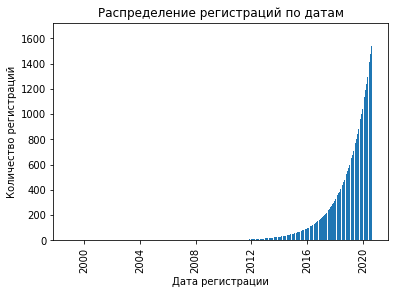

In [24]:
reg_counts = reg_data.groupby('reg_ts') \
                     .agg({'uid': 'count'}) \
                     .reset_index() \
                     .rename(columns={'uid': 'uid_counts'}) \
                     .sort_values('reg_ts')  

plt.bar(reg_counts['reg_ts'], reg_counts['uid_counts'])
plt.xlabel('Дата регистрации')
plt.ylabel('Количество регистраций')
plt.title('Распределение регистраций по датам')
plt.xticks(rotation=90)
plt.show()

Вижу что с 1998 по 2012 год регистрации было крайне мало. Тестировать функцию буду на сэмпле данных из 2020 года. 

Объединяю таблицы: к таблице со временем входа в игру (auth_data) добавляю таблицу с уникальными регистрациями пользователей в приложении (reg_data). По значению столбца reg_ts буду формировать когорты, т.к. по условию задачи требуется считать retention игроков по дням от даты регистрации игрока.

In [25]:
df = auth_data.merge(reg_data, how='left', on='uid')
df.head(3)

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22


Для объединенного датасета еще раз явно укажу формат даты (без этого шага глючит)

In [26]:
df['auth_ts'] = pd.to_datetime(df['auth_ts'])
df['reg_ts'] = pd.to_datetime(df['reg_ts'])

Рассчитаю вспомогательный столбец day_since_reg (дней с момента регистрации пользователя)

In [27]:
df['day_since_reg'] = (df['auth_ts'] - df['reg_ts']).dt.days
df.head(3)

,auth_ts,uid,reg_ts,day_since_reg
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-25,2,1999-07-22,3


Датасет получился большой, поэтому для тестирования возьму сэмпл данных за последние 2 недели.

In [29]:
start_date = df['reg_ts'].max() - pd.Timedelta(days=14)
df_1 = df[df['reg_ts'] >= start_date]

In [30]:
df_1.head(2)

,auth_ts,uid,reg_ts,day_since_reg
9372233,2020-09-09,1084183,2020-09-09,0
9372244,2020-09-09,1084184,2020-09-09,0


Дни регистрации пользователей совпадают с размером когорты, поэтому просто выполню переименование столбца:

In [31]:
df_1 = df_1.rename(columns={'reg_ts': 'cohort_day'})
df_1.head(2)

,auth_ts,uid,cohort_day,day_since_reg
9372233,2020-09-09,1084183,2020-09-09,0
9372244,2020-09-09,1084184,2020-09-09,0


Создам сводную таблицу для дальнейших расчетов. В values запишу кол-во уникальных uid для каждой когорты

In [32]:
df_cohort = df_1.pivot_table(index='cohort_day', columns='day_since_reg', values='uid', aggfunc='nunique')
df_cohort

day_since_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_day,,,,,,,,,,,,,,,
2020-09-09,1607.0,28.0,52.0,75.0,92.0,107.0,92.0,95.0,70.0,81.0,60.0,81.0,77.0,78.0,39.0
2020-09-10,1609.0,33.0,69.0,77.0,68.0,109.0,101.0,114.0,78.0,73.0,91.0,76.0,84.0,58.0,NaN
2020-09-11,1612.0,21.0,65.0,73.0,91.0,92.0,108.0,102.0,71.0,75.0,87.0,86.0,53.0,NaN,NaN
2020-09-12,1614.0,31.0,62.0,76.0,75.0,98.0,106.0,93.0,85.0,83.0,92.0,41.0,NaN,NaN,NaN
2020-09-13,1618.0,32.0,66.0,69.0,83.0,106.0,105.0,80.0,76.0,80.0,58.0,NaN,NaN,NaN,NaN
2020-09-14,1619.0,36.0,62.0,73.0,86.0,105.0,113.0,102.0,72.0,47.0,NaN,NaN,NaN,NaN,NaN
2020-09-15,1623.0,36.0,66.0,74.0,98.0,91.0,112.0,92.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-16,1625.0,31.0,69.0,75.0,76.0,110.0,113.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-17,1628.0,27.0,70.0,74.0,89.0,102.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для рассчета retention rate построчно делю каждый столбец на значение нулевого столбца (размер когорты), умножаю на 100 для получения процентов и округляю до десятых. 

In [33]:
retention = (df_cohort.div(df_cohort.iloc[:, 0], axis=0) * 100).round(1)
retention

day_since_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_day,,,,,,,,,,,,,,,
2020-09-09,100.0,1.7,3.2,4.7,5.7,6.7,5.7,5.9,4.4,5.0,3.7,5.0,4.8,4.9,2.4
2020-09-10,100.0,2.1,4.3,4.8,4.2,6.8,6.3,7.1,4.8,4.5,5.7,4.7,5.2,3.6,NaN
2020-09-11,100.0,1.3,4.0,4.5,5.6,5.7,6.7,6.3,4.4,4.7,5.4,5.3,3.3,NaN,NaN
2020-09-12,100.0,1.9,3.8,4.7,4.6,6.1,6.6,5.8,5.3,5.1,5.7,2.5,NaN,NaN,NaN
2020-09-13,100.0,2.0,4.1,4.3,5.1,6.6,6.5,4.9,4.7,4.9,3.6,NaN,NaN,NaN,NaN
2020-09-14,100.0,2.2,3.8,4.5,5.3,6.5,7.0,6.3,4.4,2.9,NaN,NaN,NaN,NaN,NaN
2020-09-15,100.0,2.2,4.1,4.6,6.0,5.6,6.9,5.7,2.5,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-16,100.0,1.9,4.2,4.6,4.7,6.8,7.0,3.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-17,100.0,1.7,4.3,4.5,5.5,6.3,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Избавлюсь от NaN для удоства чтения 

In [34]:
retention = retention.fillna('')
retention

day_since_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_day,,,,,,,,,,,,,,,
2020-09-09,100.0,1.7,3.2,4.7,5.7,6.7,5.7,5.9,4.4,5,3.7,5,4.8,4.9,2.4
2020-09-10,100.0,2.1,4.3,4.8,4.2,6.8,6.3,7.1,4.8,4.5,5.7,4.7,5.2,3.6,
2020-09-11,100.0,1.3,4,4.5,5.6,5.7,6.7,6.3,4.4,4.7,5.4,5.3,3.3,,
2020-09-12,100.0,1.9,3.8,4.7,4.6,6.1,6.6,5.8,5.3,5.1,5.7,2.5,,,
2020-09-13,100.0,2,4.1,4.3,5.1,6.6,6.5,4.9,4.7,4.9,3.6,,,,
2020-09-14,100.0,2.2,3.8,4.5,5.3,6.5,7,6.3,4.4,2.9,,,,,
2020-09-15,100.0,2.2,4.1,4.6,6,5.6,6.9,5.7,2.5,,,,,,
2020-09-16,100.0,1.9,4.2,4.6,4.7,6.8,7,3.4,,,,,,,
2020-09-17,100.0,1.7,4.3,4.5,5.5,6.3,4.2,,,,,,,,


Собираю все шаги в функцию: 

###  ФУНКЦИЯ для расчета RETENTION за последние 2 недели в датасете (one click)


In [35]:
import pandas as pd

def calculate_retention(reg_data, auth_data):
    """
    Функция рассчитывает retention игроков по дням с момента регистрации за последние 14 дней. 
    Берет данные из двух датафреймов reg_data (данные регистрациях) и auth_data (данные об авторизациях). 
    Выводит предупреждения, если: 
    + найдены авторизации без регистрации,
    + найдены регистрации без авторизаций,
    + есть дубликаты,
    + выявлены пропущенные значения 
    """
    # Проверки исходных датасетов
    missing_reg_users = set(auth_data['uid']) - set(reg_data['uid'])
    if missing_reg_users:
        print(f"Предупреждение: найдены авторизации без регистрации: {missing_reg_users}")

    missing_auth_users = set(reg_data['uid']) - set(auth_data['uid'])
    if missing_auth_users:
        print(f"Предупреждение: найдены регистрации без авторизаций: {missing_auth_users}")
    
    reg_duplicates = reg_data.duplicated().sum()
    auth_duplicates = auth_data.duplicated().sum()
    if reg_duplicates > 0 or auth_duplicates > 0:
        print(f"Предупреждение: найдены дубликаты! reg_data: {reg_duplicates}, auth_data: {auth_duplicates}") 

    reg_null = reg_data.isnull().sum()
    auth_null = auth_data.isnull().sum()
    if reg_null.sum() > 0 or auth_null.sum() > 0:
        print(f"Предупреждение: найдены пропущенные значения! reg_data: {reg_null_sum.sum()}, auth_data: {auth_null_sum.sum()}")
    
    # Преобразование timestamp в дату
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
    
    # Мердж
    df = auth_data.merge(reg_data, how='left', on='uid')

    # Столбец дней с момента регистрации
    df['day_since_reg'] = (pd.to_datetime(df['auth_ts']) - pd.to_datetime(df['reg_ts'])).dt.days

    # Сэмпл 14 последних дней
    start_date = df['reg_ts'].max() - pd.Timedelta(days=14)
    df_1 = df[df['reg_ts'] >= start_date]

    # Переименование столбца
    df_1 = df_1.rename(columns={'reg_ts': 'cohort_day'})

    # Pivot
    df_cohort = df_1.pivot_table(index='cohort_day', columns='day_since_reg', values='uid', aggfunc='nunique')

    # Считаю retention
    retention = (df_cohort.div(df_cohort.iloc[:, 0], axis=0) * 100).round(1)

    # Убираю NaN
    retention = retention.fillna('')

    return retention

# Загрузка данных
reg_data = pd.read_csv('../shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('../shared/problem1-auth_data.csv', sep=';')

# Запуск функции
retention = calculate_retention(reg_data, auth_data)

# Показать результат
retention

day_since_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_day,,,,,,,,,,,,,,,
2020-09-09,100.0,1.7,3.2,4.7,5.7,6.7,5.7,5.9,4.4,5,3.7,5,4.8,4.9,2.4
2020-09-10,100.0,2.1,4.3,4.8,4.2,6.8,6.3,7.1,4.8,4.5,5.7,4.7,5.2,3.6,
2020-09-11,100.0,1.3,4,4.5,5.6,5.7,6.7,6.3,4.4,4.7,5.4,5.3,3.3,,
2020-09-12,100.0,1.9,3.8,4.7,4.6,6.1,6.6,5.8,5.3,5.1,5.7,2.5,,,
2020-09-13,100.0,2,4.1,4.3,5.1,6.6,6.5,4.9,4.7,4.9,3.6,,,,
2020-09-14,100.0,2.2,3.8,4.5,5.3,6.5,7,6.3,4.4,2.9,,,,,
2020-09-15,100.0,2.2,4.1,4.6,6,5.6,6.9,5.7,2.5,,,,,,
2020-09-16,100.0,1.9,4.2,4.6,4.7,6.8,7,3.4,,,,,,,
2020-09-17,100.0,1.7,4.3,4.5,5.5,6.3,4.2,,,,,,,,


In [36]:
calculate_retention.__doc__

'\n    Функция рассчитывает retention игроков по дням с момента регистрации за последние 14 дней. \n    Берет данные из двух датафреймов reg_data (данные регистрациях) и auth_data (данные об авторизациях). \n    Выводит предупреждения, если: \n    + найдены авторизации без регистрации,\n    + найдены регистрации без авторизаций,\n    + есть дубликаты,\n    + выявлены пропущенные значения \n    '

Функция рабочая, позволяет получить свежие данные за последние 14 дней без каких-либо настроек (это чаще всего и нужно менеджерам и маркетологам, чтобы держать руку на пульсе), но мне не понравилось, что функция долго отрабатывает и требует знания python для выбора произвольного интервала дат. 


### ОТЛАДКА

1. Для снижения времени работы функции я определяю нужный сэмпл до мерджа, чтобы сразу получить только нужные данные.
2. Заменил pivot_table на groupby и unstack, так как последний лучше работает с большими датасетами. 
3. Не создаю новый датасет df_1, а перезаписываю df для сэмпла, чтобы не ловить предупреждения от python. 
4. Вынес нижний и верхний временной интервал сэмпла в переменные для последующей настройки.
5. Добавил переменную max_days, чтобы более гибко управлять количеством дней, за которое необходимо считать retention (существенно влияет на скорость работы функции).
6. Вынес отдельным шагом загрузку данных, преобразование timestamp в дату, а также расчет доступного для анализа интервала дат, чтобы пользователь понимал, в каких пределах он может считать retention.

### Шаг 1: Загрузка и преобразование данных. Определение доступного для анализа временного интервала.

In [37]:
# загрузка библиотек
import pandas as pd

# загрузка данных
reg_data = pd.read_csv('../shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('../shared/problem1-auth_data.csv', sep=';')

# Проверки исходных датасетов
missing_reg_users = set(auth_data['uid']) - set(reg_data['uid'])
if missing_reg_users:
    print(f"Предупреждение: найдены авторизации без регистрации: {missing_reg_users}")

missing_auth_users = set(reg_data['uid']) - set(auth_data['uid'])
if missing_auth_users:
    print(f"Предупреждение: найдены регистрации без авторизаций: {missing_auth_users}")

reg_duplicates = reg_data.duplicated().sum()
auth_duplicates = auth_data.duplicated().sum()
if reg_duplicates > 0 or auth_duplicates > 0:
    print(f"Предупреждение: найдены дубликаты! reg_data: {reg_duplicates}, auth_data: {auth_duplicates}") 

reg_null = reg_data.isnull().sum()
auth_null = auth_data.isnull().sum()
if reg_null.sum() > 0 or auth_null.sum() > 0:
    print(f"Предупреждение: найдены пропущенные значения! reg_data: {reg_null_sum.sum()}, auth_data: {auth_null_sum.sum()}")

# timestamp в дату
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date # timestamp в дату
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date # timestamp в дату
    
# определение доступного для анализа интервала (справочно)     
min_date = reg_data.reg_ts.min()
max_date = reg_data.reg_ts.max()
print(f"Доступный интервал для анализа с {min_date} по {max_date}")

Доступный интервал для анализа с 1998-11-18 по 2020-09-23


### Шаг 2: ФУНКЦИЯ для расчета RETENTION за выбранный пользователем интервал дат
По умолчанию: с 2020-09-09 по 2020-09-23

In [38]:
# функция для рассчета retention
def calculate_retention(reg_data, auth_data, start_date, finish_date):
    """
    Функция рассчитывает retention игроков по дням с момента регистрации за выбранный период. 
    Позволяет выбрать также за какое кол-во дней считать retention.    
    Берет данные из первого шага: двух датафреймов reg_data (данные регистрациях) и auth_data (данные об авторизациях). 
    Там же производит проверки на авторизации без регистрации, регистрации без авторизаций, дубликаты, пропущенные значения. 
    """ 
    reg_data_filtered = reg_data[(reg_data['reg_ts'] >= start_date) & (reg_data['reg_ts'] <= finish_date)] #выбор диапазона    
    
    df = auth_data.merge(reg_data_filtered, how='left', on='uid') # мердж отфильтованных регистраций в авторизацию
    
    df['day_since_reg'] = (df['auth_ts'] - df['reg_ts']).dt.days # новый столбец дней с момента регистрации

    df = df[df['day_since_reg'] <= max_days]  #ограничение количества дней для подсчета 

    df = df.rename(columns={'reg_ts': 'cohort_day'}) # переименование столбца

    df_cohort = df.groupby(['cohort_day', 'day_since_reg'])['uid'].nunique().unstack() # группировка и unstack

    retention = (df_cohort.div(df_cohort.iloc[:, 0], axis=0) * 100).round(1) # считаю retention

    retention = retention.fillna('') # убираю NaN

    return retention 

# НАСТРОЙКА ГРАНИЦЫ ДЛЯ РАСЧЕТА RETENTION
start_date = pd.to_datetime('2020-09-09').date() # выбрать левую границу интервала
finish_date = pd.to_datetime('2020-09-23').date() # выбрать правую границу интервала
max_days = 14 # выбрать за какое кол-во дней считать retention

# запустить функцию
retention = calculate_retention(reg_data, auth_data, start_date, finish_date)

# показать результат
retention

day_since_reg,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
cohort_day,,,,,,,,,,,,,,,
2020-09-09,100.0,1.7,3.2,4.7,5.7,6.7,5.7,5.9,4.4,5,3.7,5,4.8,4.9,2.4
2020-09-10,100.0,2.1,4.3,4.8,4.2,6.8,6.3,7.1,4.8,4.5,5.7,4.7,5.2,3.6,
2020-09-11,100.0,1.3,4,4.5,5.6,5.7,6.7,6.3,4.4,4.7,5.4,5.3,3.3,,
2020-09-12,100.0,1.9,3.8,4.7,4.6,6.1,6.6,5.8,5.3,5.1,5.7,2.5,,,
2020-09-13,100.0,2,4.1,4.3,5.1,6.6,6.5,4.9,4.7,4.9,3.6,,,,
2020-09-14,100.0,2.2,3.8,4.5,5.3,6.5,7,6.3,4.4,2.9,,,,,
2020-09-15,100.0,2.2,4.1,4.6,6,5.6,6.9,5.7,2.5,,,,,,
2020-09-16,100.0,1.9,4.2,4.6,4.7,6.8,7,3.4,,,,,,,
2020-09-17,100.0,1.7,4.3,4.5,5.5,6.3,4.2,,,,,,,,


### Повторный запуск функции с измененными параметрами

In [39]:
# НАСТРОЙКА ГРАНИЦЫ ДЛЯ РАСЧЕТА RETENTION
start_date = pd.to_datetime('2020-01-01').date() # выбрать левую границу интервала
finish_date = pd.to_datetime('2020-01-30').date() # выбрать правую границу интервала
max_days = 18 # выбрать за какое максимальное кол-во дней считать retention

# запустить функцию
retention = calculate_retention(reg_data, auth_data, start_date, finish_date)

# показать результат
retention

day_since_reg,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
cohort_day,,,,,,,,,,,,,,,,,,,
2020-01-01,100.0,2.6,4.5,3.4,5.7,5.8,7.5,5.0,4.4,4.4,5.4,6.5,4.6,4.9,4.8,4.3,4.9,4.4,4.4
2020-01-02,100.0,2.4,4.5,5.2,4.8,5.8,7.7,5.9,5.6,5.3,5.6,5.6,4.5,4.5,4.2,5.1,5.5,5.1,4.0
2020-01-03,100.0,2.3,3.4,4.4,4.5,6.9,7.5,5.4,4.5,4.2,5.3,5.8,5.5,5.4,4.6,4.6,3.8,4.4,4.3
2020-01-04,100.0,1.5,4.5,5.1,5.3,5.7,7.0,5.4,4.2,4.9,4.8,5.4,5.0,5.0,4.8,3.7,4.6,2.7,4.6
2020-01-05,100.0,2.0,4.5,4.6,4.4,4.8,7.9,5.2,3.9,5.4,4.1,4.9,3.8,4.3,4.2,4.5,4.2,3.8,3.8
2020-01-06,100.0,2.9,4.5,5.0,3.8,4.7,6.6,5.9,5.2,5.0,5.3,5.0,4.0,4.0,4.6,5.0,4.4,4.3,3.6
2020-01-07,100.0,1.9,4.9,4.4,6.4,5.0,8.5,5.1,5.7,5.3,5.8,4.9,5.3,4.9,5.2,5.0,4.9,4.8,4.2
2020-01-08,100.0,2.2,4.0,4.3,5.1,5.0,8.5,5.0,4.5,6.2,4.2,4.8,5.5,4.2,3.5,3.8,5.0,3.3,4.1
2020-01-09,100.0,1.9,4.0,5.5,4.5,6.0,6.7,5.7,5.1,4.7,4.6,3.9,5.1,4.9,4.5,4.2,4.1,4.2,4.7


# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

#### Импорт библиотек:

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, anderson, levene, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

#### Загрузка датасета с результатами A/B теста:

In [48]:
ab = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

#### Исследование данных:

In [49]:
ab

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [50]:
ab.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [51]:
ab.shape

(404770, 3)

In [52]:
ab.user_id.nunique()

404770

In [53]:
ab.duplicated().sum()

0

In [54]:
ab.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [55]:
ab.testgroup.unique()

array(['b', 'a'], dtype=object)

Проверю, насколько данные из условия задачи соответсвую данным из загруженного датасета:

In [56]:
summary_df = ab.groupby('testgroup').agg(
    total_users=('user_id', 'nunique'),
    paying_users=('user_id', lambda x: x[ab['revenue'] > 0].nunique()),
    total_revenue=('revenue', 'sum'),
    ARPU=('revenue', 'mean')
)

summary_df

,total_users,paying_users,total_revenue,ARPU
testgroup,,,,
a,202103,1928,5136189,25.413720
b,202667,1805,5421603,26.751287


ARPU в тестовой группе выше чем в контрольной на (%):

In [57]:
((summary_df.ARPU['b'] - summary_df.ARPU['a']) / summary_df.ARPU['a'] * 100).round(1)

5.3

Общее количества игроков в тестовой группе больше чем в контрольной на (%):

In [58]:
((summary_df.total_users['b'] - summary_df.total_users['a']) / summary_df.total_users['a'] * 100).round(1)

0.3

####  По результатам предварительного анализа данных можно сказать:
1. Данные из условия задачи соответсвуют данным из датасета (ARPU в условии округлен до целого)
2. Определил что «a» - контрольная группа, «b» - тестовая группа
3. Все user_id ункальные и соответсвуют количеству строк датасета, что в свою очередь также говорит о том, что пользователи в контрольной и тестовой группах не пересекаются, тестирование произведено корректно. 
4. Дубликатов и пропущенных значений нет
5. Размер выборок пользователей в тестовой и контрольных группах можно считать одинаковым из-за несущественной разницы в 0.3% 

### Выбор метрик

Для того, чтобы определить какой набор предложений можно считать лучшим в качестве метрик я возьму **средний доход на пользователя (ARPU)** и **средний доход на платящего пользователя (ARPPU)**. Первый позволит оценить, насколько успешно компания привлекает и монетизирует пользователей. Второй позволит оценить, как изменения стоимости акционных предложений влияет на поведение платящих пользователей.

Также я буду смотреть **конверсию в платежи (CR)** для каждой группы, чтобы понять повлияло ли тестовое предложение на вовлечение пользователей в оплату. Я считаю это важной метрикой, т.к. в игровой индустрии есть такое понятие как эффект "первой покупки". 
_Исследование Дж. Хамари и В. Лехтонен показало, что если игрок совершает первую покупку в игре, даже если она небольшая, то в дальнейшем он с большей вероятностью будет делать повторные покупки. Это связано с тем, что первая покупка снижает психологический барьер и повышает готовность игрока тратить деньги в игре. Аналогичные результаты были получены в исследовании Д. Ким и Дж. Ким. Они обнаружили, что игроки, которые сделали первую покупку, в дальнейшем тратили в 3-4 раза больше денег, чем игроки, которые не совершали никаких покупок._

In [59]:
# дополню таблицу вычислением CR и ARPPU:
summary_df = ab.groupby('testgroup').agg(
    total_users=('user_id', 'nunique'),
    paying_users=('user_id', lambda x: x[ab['revenue'] > 0].nunique()),
    total_revenue=('revenue', 'sum'),
    ARPU=('revenue', 'mean'),
    ARPPU=('revenue', lambda x: x[x > 0].mean()),
    CR=('user_id', lambda x: x[ab['revenue'] > 0].count() / x.count() * 100)
).round(2)

summary_df

,total_users,paying_users,total_revenue,ARPU,ARPPU,CR
testgroup,,,,,,
a,202103,1928,5136189,25.41,2664.00,0.95
b,202667,1805,5421603,26.75,3003.66,0.89


Теперь у меня


есть все необходимые метрики, но осталось понять насколько данные результаты являются статистически значимыми.

Начну с **CR**:

In [60]:
(summary_df.CR['b'] - summary_df.CR['a']).round(2)

-0.06

CR в контрольной группе выше на 0.06%, чем в тестовой. 

Проверю статисчитескую значимость различий между двумя группами с помощью **Z-теста:** 
* H0: Нет различий в конверсии между двумя группами
* H1: Есть различия в конверсии между двумя группами

In [61]:
count_paying_users = np.array([summary_df.paying_users['a'], summary_df.paying_users['b']])
count_total_users = np.array([summary_df.total_users['a'], summary_df.total_users['b']])
proportions_ztest(count_paying_users, count_total_users)

(2.108028495889841, 0.035028524642854865)

pvalue 0.035 < 0.05 значит различия в конверсии между группами статистически значимы. Можно утверждать, что **наборы акционных предложений для тестовой группы не так эффективно  привлекает  платящих  пользователей,  как  контрольное.**    

In [62]:
((summary_df.ARPU['b'] - summary_df.ARPU['a']) / summary_df.ARPU['a'] * 100).round(1)

5.3

ARPU в тестовой группе выше на 5.3%, чем в контрольной. Это может говорить о том, что тестовое предложение не сильно повлияло на привлечение новых пользователей. Но это предположение еще нужно проверить на стат.значимость. 

In [63]:
((summary_df.ARPPU['b'] - summary_df.ARPPU['a']) / summary_df.ARPPU['a'] * 100).round(1)

12.7

ARPPU в тестовой группе выше на 12.7%, чем в контрольной. Это может говорить о том, что тестовое предложение более эффективно привлекает платящих пользователей и стимулирует их тратить больше денег. Предположение также требует проверки на стат.значимость.

В целом же, я вижу что внутри двух групп ARPPU более чем в 100 раз превышает ARPU, что говорит о невысоком проценте платящих пользователей в компании. 

#### Смотрю на распределение платящих пользователей по группам:

In [64]:
# контрольная группа
a_pay = ab.query('revenue > 0 and testgroup == "a"').sort_values('revenue')['revenue']

In [65]:
# тестовая группа
b_pay = ab.query('revenue > 0 and testgroup == "b"').sort_values('revenue')['revenue']

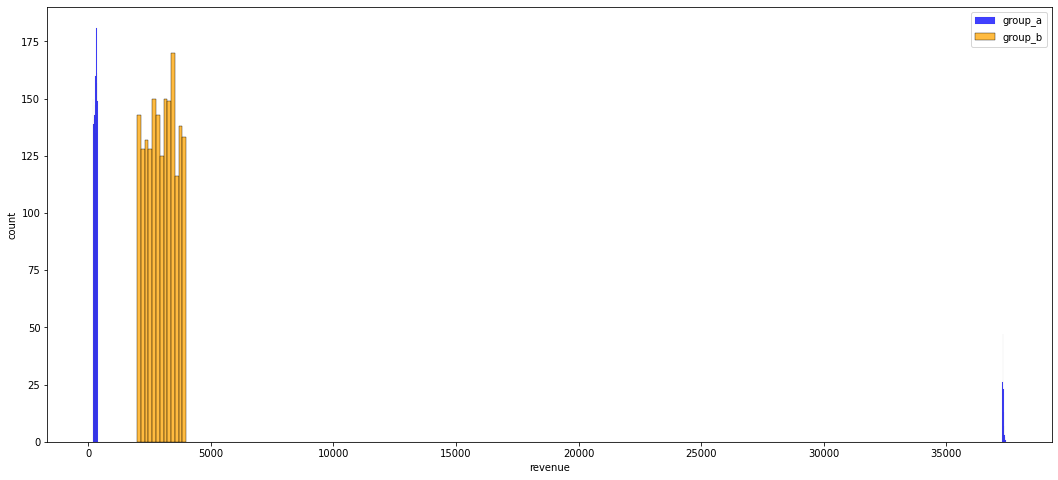

In [66]:
plt.figure(figsize=(18, 8))
sns.histplot(a_pay, label='group_a', kde=False, color='blue')
sns.histplot(b_pay, label='group_b', kde=False, color='orange')
plt.xlabel('revenue')
plt.ylabel('count')
plt.legend()
plt.show()

**Контрольная группа:** Данные однозначно не являются нормально распределенными. Группа имеет выраженную правостороннюю асимметрию, т.е. большая часть значений сосредоточена в левой части распределения, затем сильная разреженность или отсутвие значений в центральной части (нужно проверить), а хвост распределения тянется вправо за счет концентрированного существенного количества значений, которые похожи на выбросы (нужно проверить выбросы ли это).  

**Тестовая группа:** распределение более симметрично чем в контрольной, без явных выбросов.

Посмотрю детальнее на левую и правую часть из контрольной группы и отдельно на распределение тестовой:

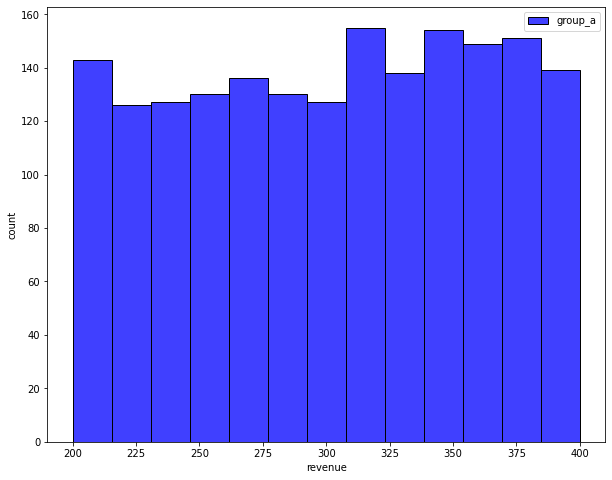

In [67]:
# контрольная группа, левая часть распределения
a_pay_left = ab.query('revenue > 0 and revenue < 1000 and testgroup == "a"').sort_values('revenue')['revenue']

plt.figure(figsize=(10, 8))
sns.histplot(a_pay_left, label='group_a', kde=False, color='blue')
plt.xlabel('revenue')
plt.ylabel('count')
plt.legend()
plt.show()

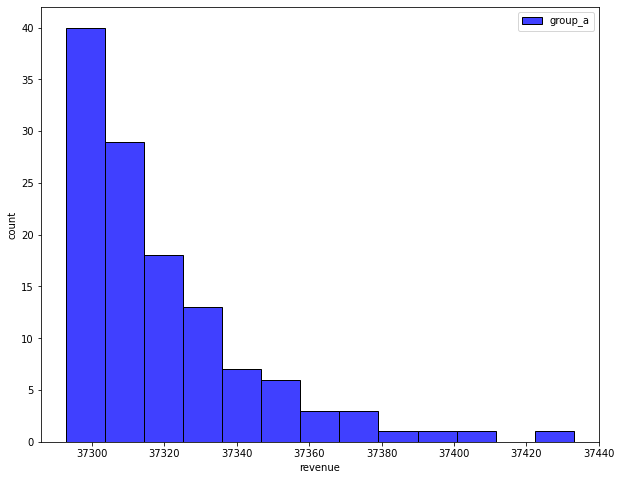

In [68]:
# контрольная группа, правая часть распределения
a_pay_right = ab.query('revenue > 35000 and testgroup == "a"').sort_values('revenue')['revenue']

plt.figure(figsize=(10, 8))
sns.histplot(a_pay_right, label='group_a', kde=False, color='blue')
plt.xlabel('revenue')
plt.ylabel('count')
plt.legend()
plt.show()

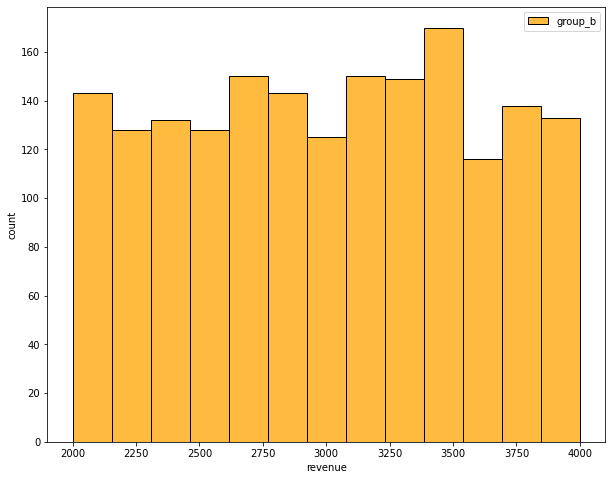

In [69]:
# тестовая группа
plt.figure(figsize=(10, 8))
sns.histplot(b_pay, label='group_b', kde=False, color='orange')
plt.xlabel('revenue')
plt.ylabel('count')
plt.legend()
plt.show()

In [70]:
a_pay.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

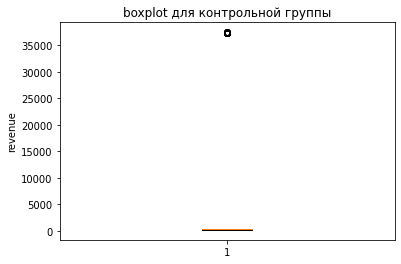

In [71]:
plt.boxplot(a_pay)
plt.title('boxplot для контрольной группы')
plt.ylabel('revenue')
plt.show()

In [72]:
b_pay.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

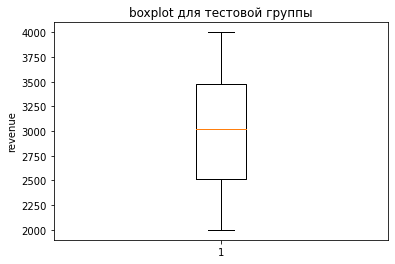

In [73]:
plt.boxplot(b_pay)
plt.title('boxplot для тестовой группы')
plt.ylabel('revenue')
plt.show()

In [74]:
a_pay_left.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

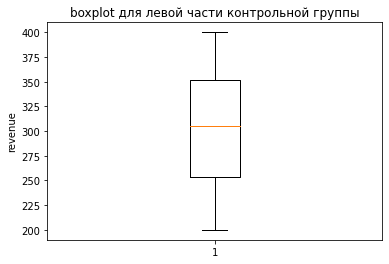

In [75]:
plt.boxplot(a_pay_left)
plt.title('boxplot для левой части контрольной группы')
plt.ylabel('revenue')
plt.show()

In [76]:
a_pay_right.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

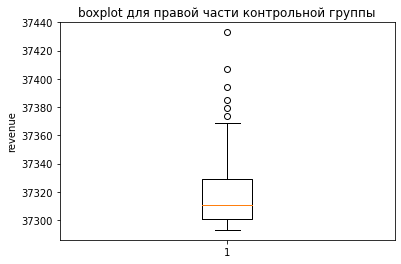

In [77]:
plt.boxplot(a_pay_right)
plt.title('boxplot для правой части контрольной группы')
plt.ylabel('revenue')
plt.show()

Кол-во платежей в левой части распределения контрольной группы больше в 15 раз чем в правой: 

In [78]:
a_pay_left.count() / a_pay_right.count()

14.674796747967479

Сумма выручки в правой части распределения контрольной группы в 8 раз больше чем левой:

In [79]:
a_pay_right.sum() / a_pay_left.sum()

8.40802510179746

В распределении контрольной группы полностью отсутвуют средние значения выручки (сумма левых и правых равна сумме всех значений):

In [80]:
a_pay_right.sum() + a_pay_left.sum()

5136189

In [81]:
a_pay.sum()

5136189

Топ-10 платящих пользователей из контрольной группы:

In [82]:
ab.query('revenue > 37000 and testgroup == "a"').sort_values('revenue')['user_id'].tail(10).to_list()

[287699, 76987, 175826, 174391, 229055, 142805, 21586, 65078, 196602, 101862]

## Перепроверка данных

Прежде чем дальше анализировать данные, я бы запросил у компании, которая проводила а/б тест: 
1. проверку данных по топ-10 пользователям контрольной группы, которые совершили платежи на сумму превышающую 37 000 по следующим ID:  287699, 76987, 175826, 174391, 229055, 142805, 21586, 65078, 196602, 101862. В ходе анализа у меня возникли подозрения, что в статистике могут присутвут ошибки. Например, компания могла начислять валюту на промо-аккаунты игровым стримерам, которая в свою очередь попала в статистику как выручка. Либо возникла какая-то другая ошибка. Основание проверки: сумма выручки пользователей правой группы (их всего 6% от всех платящих пользователей) в 8 раз больше чем в левой и полное отсутвие промежуточных платежей между группами в контрольной выборке.  
2. также у меня вызывает сомнение факт зеркальной кратности цифр в контрольной группе для левого распределения и тестовой: в левом распределении контрольной группы min/max значение выручки 200-400, а в тестовой от 2000-4000. Цифры получились кратными 10, что также достаточно странно.  

Если будет вывлена ошибка, то анализ нужно будет повторить с актуальными данными, или провести новый эксперимент. 

## Допущение
Далее я буду считать что мне ответили: ошибки нет и у нас действительно есть пользователи, которые тратят очень много денег, а суть акционного предложения заключалась в том, что компания продавала годовую подписку по цене 10 месяцев (отсюда рост выручки по пользователям кратный 10). Продолжаю исследование:


#### Проверка распределения на нормальность

Хотя и так четко видно из графиков, что распределение ненормальное, убедимся в этом проведя тест Колмогорова-Смирнова и Андерсона-Дарлинга. Тест Шапиро-Уилка в данном случае не подходит, т.к. он более эффективен для небольших выборок.

Гипотезы:
* H0: Данные имеют нормальное распределение.
* H1: Данные не имеют нормального распределения.

In [83]:
kstest(a_pay, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [84]:
kstest(b_pay, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

Данные в контрольной и в тестовой группах не являются нормальными, т.к. pvalue < 0.05

И еще один тест Андерсона-Дарлинга, т.к он является более чувствительным к отклонениям в хвостах распределения (а это как раз наш случай для контрольной выборки):

In [85]:
anderson(a_pay)

AndersonResult(statistic=670.062170731122, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [86]:
anderson(b_pay)

AndersonResult(statistic=18.09928907207336, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Статистика теста для контрольной группы (670.06) очень велика по сравнению с критическими значениями. Это значит что с очень высокой вероятностью pvalue будет даже меньше 0.01, т.е. распределение ненормальное. 

Статистика теста для тестовой группы (18.1) также больше критических значений, но не настолько как для контрольной группы, т.е. распределение тестовой группы ближе к нормальному, но все же от него отличается. Нулевая гипотеза о нормальности распределения также отвергается.

#### Проверка равенства дисперсий между группами

В проведении теста Левина также нет смысла, т.к. из визуального осмотра и из описательной статистики видно, что стандартные отклонения различаются более чем в 15 раз (9049 для контрольной группы против 572 для тестовой группы). Это очевидный признак того, что дисперсии в этих группах неравны, но чтобы соблюсти формальность проведем этот тест.

Гипотезы:
* H0: Дисперсии в группах равны
* H1: Дисперсии в группах отличаются

In [87]:
levene(a_pay, b_pay, center='mean')

LeveneResult(statistic=445.98694470660877, pvalue=1.3202514573715939e-93)

pvalue получился очень маленький, гораздо меньше 0.05, что позволяет отвергнуть нулевую гипотезу о равенстве дисперсий в группах с высокой уверенностью.

#### Выбор теста для проверки статистически значимых различий по выручке:

**Контрольная группа.** 
Данные распределены ненормально. Очень высокое стандартное отклонение (9049) указывает на большой разброс значений. Это же подтверждается данными на графике. Группа имеет выраженную правостороннюю асимметрию, т.е. большая часть значений сосредоточена в левой части распределения. Это же подтверждает описательная статистика, где среднее значение выручки составляет 2664, а медиана - 311. Вероятнее всего акционные предложения в контрольной группе имели четкую сегментацию, поскольку пользователи имели возможность тратить либо очень мало (от 200 до 400), либо очень много денег (от 37293 до 37433). Если попробовать посмотреть на распределние контрольной группы как на 2 разных распределения, то можно сказать: 
* Левая часть распределения компактная: стандартное отклонение 57.91, минимальное (200) и максимальное значение (400) находятся в относительно узком диапазоне. 
* Правый хвост однозначно не является выбросом, а представляет собой очень узкий сегмент пользователей (стандартное отклонение 25.44) с высокой ценностью, в котором игроки совершают очень крупные покупки (от 37293 до 37433). В этом сегменте всего 6% от всех платящих пользователей контрольной группы (123 из 1928), но он приносит в 8 раз больше выручки, чем остальные платящие пользователи. 

**Тестовая группа.** 
Имеет более симетричное распределение: стандартное отклонение 573, а медиана 3022 и среднее 3003 практически равны. При этом распределение также не является нормальным. Разница между минимальным (2000) и максимальным (4000) значениями меньше, чем в контрольной группе. 

Применю модификацию t-теста Стьюдента, а именно - t-тест Уэлча для сравнения средних значений ARPU и ARPPU. Мой выбор обусловлен тем, что данный тест не требует равенства дисперсий в группах. 

Гипотезы:
* H0: Средние значения в группах A и B равны
* H1: Средние значения в группах A и B различаются

Подготовка данных:

In [88]:
# извлекаю данные ARPU и ARPPU из summary_df
arpu_a = summary_df.loc['a', 'ARPU']
arpu_b = summary_df.loc['b', 'ARPU']
arppu_a = summary_df.loc['a', 'ARPPU']
arppu_b = summary_df.loc['b', 'ARPPU']

# считаю revenue для всех пользователей
revenue_a = ab.query('testgroup == "a"')['revenue']
revenue_b = ab.query('testgroup == "b"')['revenue']

# прим.: revenue для платящих считал выше (a_pay, b_pay)

In [91]:
# t-теста Уэлча для ARPU (все пользователи)
ttest_ind(revenue_a, revenue_b, equal_var=False)

Ttest_indResult(statistic=-0.6234876562792212, pvalue=0.5329647014130866)

**ARPU:** Поскольку pvalue значительно больше 0.05, мы не можем отвергнуть нулевую гипотезу, т.е.средние значения ARPU в контрольной и тестовой группах не различаются статистически значимо.

In [92]:
# t-теста Уэлча для ARPPU (только платящие пользователи)
ttest_ind(a_pay, b_pay, equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

**ARPPU:** pvalue также больше 0.05, что приводит к тому же выводу: мы не можем отвергнуть нулевую гипотезу. Это говорит о том, что средние значения ARPPU в контрольной и тестовой группах также не различаются статистически значимо.

In [93]:
summary_df

,total_users,paying_users,total_revenue,ARPU,ARPPU,CR
testgroup,,,,,,
a,202103,1928,5136189,25.41,2664.00,0.95
b,202667,1805,5421603,26.75,3003.66,0.89


### Выводы:

Метрики ARPU и ARPPU не показали статистически значимых различий, что свидетельствует о том, что предложения тестовой выборки не оказали ожидаемого влияния на общую выручку пользователей и доход от платящих. В то же время, была выявлена статистически значимая разница по CR, что указывает на более высокую эффективность контрольной группы в привлечении платящих пользователей.
На основании вышеизложенного, **рекомендую оставить контрольную выборку**, так как изменения, предложенные в тестовой группе, не привели к улучшению ключевых метрик. 

### Рекомендации:
Отделу маркетинга следует обратить внимание на сегмент пользователей из правого хвоста контрольной выборки (6%). Очевидно, что эти игроки могут тратить в сотни раз больше денег на игру. Не стоит ограничивать их даже потолком в 4000, который был установлен в тестовой выборке. Важно понять, за что именно игроки готовы платить такие суммы, и постараться предоставить им эту возможность.

Стоит отметить, что многочисленный, но не приносящий доход сегмент пользователей из левой части контрольной выборки также готов тратить многократно больше (в десять раз). Возможно, стоит разработать для них новые предложения с более высокой стоимостью (в настоящий момент установлен потолок в 400), но при этом не следует забывать о пользователях из контрольной выборки, которые тратили минимальные суммы. За счет этих пользователей конверсия в платежи в контрольной выборке выше, чем в тестовой, что может положительно сказаться на привлечении пользователей, которые никогда не платили за игру ранее, создавая эффект "первой покупки".

После этого стоит провести новый A/B тест, так как, на мой взгляд, существует потенциал для увеличения ARPU и ARPPU.   

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Метрики

### _Кейс 1: Оценка результатов игрового события с прохождением уровней за определенное время_

#### Вовлеченность:
1. Количество игроков, принявших участие в событии
2. Доля участников события от общего числа игроков
3. Среднее время, проведенное игроками в игре во время события
4. Процент прохождения игроками необходимого количества уровней за время события (100% = полное прохождение)
5. Время, затраченное игроками на прохождение каждого этапа события
6. Общее время, необходимое для полного прохождения события

#### Монетизация:
1. Количество платящих игроков, участвовавших в событии
2. Доля игроков, совершавших покупки во время события
3. Средняя сумма покупки игроками во время события
4. Общая выручка от события
5. ARPU (средний доход на пользователя) во время события
6. ARPPU (средний доход на платящего пользователя) во время события
7. Конверсия в покупку уникальных предметов, доступных только в рамках данного события (если такие имеются)

#### Возврат:
* Retention rate (доля игроков, продолживших играть после события) - для оценки "выгорания" игроков

#### Дополнительная метрика:
* Процент новых игроков. Этой метрикой также можно косвенно оценить и сетевую активность связанную с событием, анализировать которую отдельно для внутриигровых событий может быть экономически нецелесообразным. Вынес метрику во второстепенные, т.к. событие все же рассчитано на текущую аудиторию, уже погруженную в игровой контекст.

**Примечание:** Сравнивать метрики следует с периодом без событий, а также с предыдущими событиями для оценки успешности и улучшения баланса будущих событий.


### _Кейс 2: Усложнение механики с откатом на несколько уровней при неудаче_

Кроме текущих, можно добавить следующие метрики:
1. Процент игроков, бросивших попытки пройти событие
2. Среднее количество откатов на несколько уровней назад
3. Уровень удовлетворенности игроков новыми изменениями (на основе опросов)
4. Количество жалоб/отзывов, связанных с усложненной механикой на внутриигровых платформах, а также отзывах и рейтинге в магазинах приложений (ручной мониторинг отделом маркетинга)

**Примечание:** В метрике "Время, затраченное игроками на прохождение каждого этапа события" нужно будет проверить, чтобы не происходило задубливание времени на выполнение каждого повторного шага события пользователем, т.к. это исказит картину при анализе сложности заданий на уровне.

